In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import List
import random
import math
import glob

from tqdm.auto import tqdm

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from utils import query_OAI_with_retries, save_dict_of_dfs_with_df_elements, load_dict_of_dfs_with_df_elements
from gpt_classification import (
    gpt_classify,
    consecutive_classify,
    run_gpt_classification,
    gpt_explain_reasoning,
    gpt_classify_using_rule,
    consecutive_classify_using_rule,
)
from data_functions import balanced_dataset
from shakespeare import comedy_of_errors

# Initial exploration of the example classification task

In [3]:
labelled_examples = pd.DataFrame([
    (s.split('"')[1], s.split('Label: ')[1])
    for s in
"""
Input: "the cat sat on the mat" Label: True
Input: "THE DOG RAN IN THE PARK" Label: False
Input: "THE mat sat on the cat" Label: False
Input: "the house is cold" Label: True
""".split('\n')
    if s
],
    columns=['text', 'label']
)

print(labelled_examples)

                      text  label
0   the cat sat on the mat   True
1  THE DOG RAN IN THE PARK  False
2   THE mat sat on the cat  False
3        the house is cold   True


In [4]:
for test in [
    'something like this',
    'the fox jumped over the bench',
    'the Fox jumped over the bench',
    'the Fox jumped over the bench'.upper(),
    'the Fox jumped over the bench'.title(),
]:
    print(test)
    print(gpt_classify(labelled_examples, test))

something like this
True
the fox jumped over the bench
True
the Fox jumped over the bench
True
THE FOX JUMPED OVER THE BENCH
True
The Fox Jumped Over The Bench
False


### Looks like it's just guessing, probably it needs more than 4 examples :p

# Create a dataset with mixed-case and lower-case

Grab some text from the internet, and split by islower.
Could instead generate sentences.

(Spoiler: Turns out that shorter sentences are more likely to be islower, so later we'll do this differently.)

In [5]:
def is_lowercase(s: str):
    return s.islower()

In [6]:
lines = pd.DataFrame(comedy_of_errors, columns=['text'])
lines['label'] = lines['text'].apply(is_lowercase)
lines

,text,label
0,,False
1,"Proceed, Solinus, to procure my fall,",False
2,And by the doom of death end woes and all.,False
3,"Merchant of Syracusa, plead no more.",False
4,I am not partial to infringe our laws.,False
...,...,...
1894,"Till then, lead thou first.",False
1895,"Nay, then, thus:",False
1896,"We came into the world like brother and brother,",False
1897,"And now let’s go hand in hand, not one before",False


In [7]:
balanced_dataset(lines, is_lowercase)

,text,label
668,door.,True
1163,tell.,True
446,dinnertime?,True
1448,Come to the Centaur. Fetch our stuff from thence.,False
798,kindness.,True
...,...,...
320,"too well feel his blows, and withal so doubtfully",True
1214,"man, sir, that, when gentlemen are tired, gives",True
1756,"But he, I thank him, gnawed in two my cords.",False
1708,"And, gazing in mine eyes, feeling my pulse,",False


In [8]:
# Load the files, if we've run this before, else calculate & save

stem = 'balanced_lines_classification_results'

if glob.glob(f'data/{stem}*feather'):
    balanced_lines_classification_results = load_dict_of_dfs_with_df_elements(
        filename_stem=stem,
        models_to_load=['gpt-3.5-turbo', 'gpt-4']
    )
else:
    balanced_lines_classification_results = run_gpt_classification(
        balanced_dataset(lines, is_lowercase),
        models_to_run=['gpt-3.5-turbo', 'gpt-4']
    )
    save_dict_of_dfs_with_df_elements(
        balanced_lines_classification_results,
        stem
    )

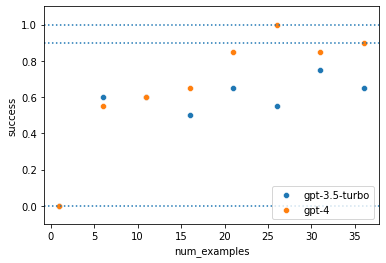

In [33]:
for model, df in balanced_lines_classification_results.items():
    sns.scatterplot(data=df, x='num_examples', y='success', label=model)
plt.ylim(-0.1, 1.1)
plt.axhline(0, linestyle=':')
plt.axhline(0.9, linestyle=':')
plt.axhline(1, linestyle=':')
plt.savefig('report/images/lowercase-classification-with-correlation.png')

### Ok, looks like GPT-4 can classify at ~30 examples (GPT-3.5 doesn't do great). Now let's check reasoning.

# Explaining Reasoning

In [10]:
num_examples = 40

gpt_explain_reasoning(balanced_dataset(lines, is_lowercase).sample(
    n=num_examples, random_state=42))

'The classification rule is: if the statement is a complete sentence or question, it is labeled as False. If the statement is a fragment or partial sentence, it is labeled as True.'

### This is funny, as length-of-text is probably what's actually being looked at, because our initial dataset is correlated in this way. When we built the dataset we did this by looking at which text lines are *already* lower-case (which likely correlates with length and sentence-fragmentation) rather than constructing the data such that lines have equal length. Let's check...

In [30]:
df = balanced_dataset(lines, is_lowercase)
df['num_words'] = df['text'].apply(lambda s: len(s.split()))
df

,text,label,num_words
668,door.,True,1
1163,tell.,True,1
446,dinnertime?,True,1
1448,Come to the Centaur. Fetch our stuff from thence.,False,9
798,kindness.,True,1
...,...,...,...
320,"too well feel his blows, and withal so doubtfully",True,9
1214,"man, sir, that, when gentlemen are tired, gives",True,8
1756,"But he, I thank him, gnawed in two my cords.",False,10
1708,"And, gazing in mine eyes, feeling my pulse,",False,8


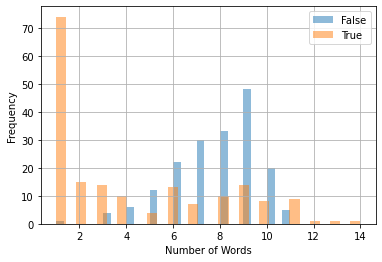

In [31]:
df.groupby('label')['num_words'].hist(bins=30, alpha=0.5, stacked=True)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend(['False', 'True'])
plt.savefig('report/images/word-count-correlating-with-lowercase-class.png')

### Yep, this well-separates the data.

# Let's make a new dataset to decorrelate from length: take the existing dataset and `.lower()` a randomly-selected half of it

In [13]:
lines_lowered = lines.copy()
# Drop lines which are already lower-case, to remove length-correlation
lines_lowered = lines_lowered[lines_lowered['text'].apply(is_lowercase) == False]

random_half_indices = lines_lowered.sample(frac=0.5, random_state=42).index
lines_lowered.loc[random_half_indices, 'text'] = lines_lowered.loc[random_half_indices, 'text'].str.lower()
lines_lowered['label'] = lines_lowered['text'].apply(is_lowercase)

In [14]:
balanced_lines_lowered = balanced_dataset(lines_lowered, is_lowercase)
balanced_lines_lowered

,text,label
532,"wouldst thou not spit at me, and spurn at me,",True
846,"What, are you mad that you do reason so?",False
168,"and stay there, dromio, till i come to thee.",True
214,to pay the saddler for my mistress’ crupper?,True
198,"in quest of them, unhappy, lose myself.",True
...,...,...
704,"So, come help. Well struck! There was blow fo",False
609,"Sirrah, if any ask you for your master,",False
1358,"Where would you had remained until this time,",False
710,"You’ll cry for this, minion, if I beat the doo...",False


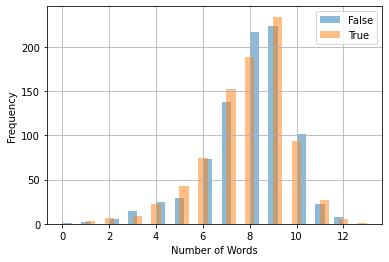

In [32]:
# Double-check length-correlation
df = balanced_lines_lowered
df['num_words'] = df['text'].apply(lambda s: len(s.split()))

df.groupby('label')['num_words'].hist(bins=30, alpha=0.5, stacked=True)

plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend(['False', 'True'])
plt.savefig('report/images/word-count-decorrelated-from-lowercase-class.png')

In [16]:
# Load the files, if we've run this before, else calculate & save

stem = 'forced_lowercase_classification_results'

if glob.glob(f'data/{stem}*feather'):
    forced_lowercase_classification_results = load_dict_of_dfs_with_df_elements(
        filename_stem=stem,
        models_to_load=['gpt-3.5-turbo', 'gpt-4']
    )
else:
    forced_lowercase_classification_results = run_gpt_classification(
        balanced_lines_lowered,
        max_num_examples=100,
        models_to_run=['gpt-3.5-turbo', 'gpt-4']
    )
    save_dict_of_dfs_with_df_elements(
        forced_lowercase_classification_results,
        stem
    )

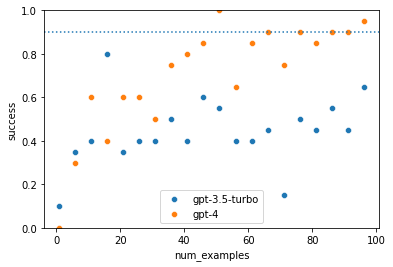

In [34]:
for k, v in forced_lowercase_classification_results.items():
    sns.scatterplot(data=v, x='num_examples', y='success', label=k)

plt.ylim(0, 1)
plt.axhline(0.9, linestyle=':')
plt.legend(loc='lower center')
plt.savefig('report/images/lowercase-classification-without-correlation.png')

### Ok, looks like we get fairly-reliable good classification from ~50 examples.

### What's the reasoning now?

In [18]:
for num_examples in [20, 35, 40, 80, 100]:
    print('===', num_examples, '===')
    print(gpt_explain_reasoning(balanced_lines_lowered.sample(n=num_examples,
                                                              random_state=42)))

=== 20 ===
The classification rule seems to be that statements starting with the word 'when', but, ah, my and our are labelled as True. All other statements are labelled as False.
=== 35 ===
The classification rule seems to be that statements where the speaker is posed in various situations or forming a question are labeled as true, while statements where the speaker expresses a view, describes a situation or is in action are labeled as false.
=== 40 ===
The classification rule is: statements that are structured as questions or exclaimations are given the label "True". All other types of statements are given the label "False".
=== 80 ===
The classification rule appears to label any Shakespearean verse that is in the form of a question or has a transitive property i.e., it involves an action performed by a subject to an object as True. Statements that involve proclamations or assertions are labeled as False.
=== 100 ===
The classification rule seems to be: statements are labelled "True"

### Ok interesting, looks like it's still not describing "is_lower", even in regimes where classification accuracy is good.

### It would be strange if this classification rule was correct, but it's harder to check than for the earlier attempt. Let's ask GPT to mark its own work...

# Let's see how GPT-4 does when told to use the rules it claims to detect

### First try on the training data given to gpt_explain_reasoning...

In [19]:
train, test = train_test_split(balanced_lines_lowered, train_size=100, random_state=42)

In [20]:
gpt_explain_reasoning(train)

"The classification rule seems to be selecting for statements that are introspective, self-referential or containing a sentiment or moral judgment. Statements that are either factual or part of interpersonal dialogue are labeled as 'False'."

In [21]:
responses, correct, success_ratio = consecutive_classify_using_rule(
    train.sample(n=20, random_state=42),
    rule="""
The classification rule is "True" for sentences that contain or imply
a speaker taking action or expressing a subjective thought or emotion,
whereas sentences labelled "False" are primarily attempts at communicating with others,
asking questions, or stating facts/observations.'
""",
    model='gpt-4'
)
success_ratio

  0%|          | 0/20 [00:00<?, ?it/s]

0.4

### ... and then on held-out samples

In [22]:
responses, correct, success_ratio = consecutive_classify_using_rule(
    test.sample(n=20, random_state=42),
    rule="""
The classification rule is "True" for sentences that contain or imply
a speaker taking action or expressing a subjective thought or emotion,
whereas sentences labelled "False" are primarily attempts at communicating with others,
asking questions, or stating facts/observations.'
""",
    model='gpt-4'
)
success_ratio

  0%|          | 0/20 [00:00<?, ?it/s]

0.4

### So it looks like it's either not succeeding (~0.5 for train & test)
### or it sometimes overfits to the training examples: eg. success(train) = 0.7, success(test) = 0.4

# Let's think about multi-choice. How much info do we leak by mentioning letter-case?

# Hinting

In [23]:
for num_examples in [20, 35, 40, 80, 100]:
    print('===', num_examples, '===')
    print(gpt_explain_reasoning(
        balanced_lines_lowered.sample(n=num_examples),
        system_prompt=(
            "You are given some statements, which are labelled with categories. "
            "Describe the classification rule."
            "(Hint: consider the letter case)"
        )
    ))

=== 20 ===
The classification rule is depends on the first letter of the sentence. If the sentence starts with a lowercase letter, it's labelled as 'True'. If the sentence starts with an uppercase letter, it's labelled as 'False'.
=== 35 ===
The classification rule is that if the first letter in the sentence is not capitalized, the label is 'True'. If it is capitalized, the label is 'False'.
=== 40 ===
The classification rule is based on the letter case. If a statement starts with a lowercase letter, it is labelled 'True.' On the other hand, if a statement starts with an uppercase letter, it is labelled 'False.'
=== 80 ===
The classification rule is: statements with the first letter of all words in lowercase are labeled as 'True', and statements with the first letter of the first word in uppercase are labeled as 'False'.
=== 100 ===
The classification rule is: if the statement starts with a lowercase letter, it is labelled as 'True'. If it starts with an uppercase letter, it is labelle

It looks like there's basically two classification rules being suggested, when a "letter-case" hint is given:
- *"if the first letter of the statement is in lower case, then the label is True"*
- *"if the sentence is written in lowercase, it is labeled as True, and if it is written in capital letters, it is labeled as False."*

Neither is *quite* correct, but the second is close. (Sentences labeled 'False' *contain* capitals, they're not "written in" capitals.)

### Let's compare the scores of these two rules, to each other and to GPT-4's classification success.

*"if the first letter of the statement is in lower case, then the label is True"*

In [24]:
first_letter_is_lower_case = balanced_lines_lowered['text'].apply(
    lambda s: s[0].islower() if s else False)

correct = (first_letter_is_lower_case == balanced_lines_lowered['label'])
sum(correct) / len(correct)

0.980791618160652

*"if the sentence is written in lowercase, it is labeled as True, and if it is written in capital letters, it is labeled as False."*

In [25]:
sentence_is_lower_case = balanced_lines_lowered['text'].apply(
    lambda s: s.islower() if s else False)

correct = (sentence_is_lower_case == balanced_lines_lowered['label'])
sum(correct) / len(correct)

1.0

*... and if it is written in capital letters, it is labeled as False."*

In [26]:
sentence_is_upper_case = balanced_lines_lowered['text'].apply(
    lambda s: s.isupper() if s else False)

sentence_is_upper_case.sum()

0

### Since hinting about letter-case leads GPT-4 to successfully identify a good (>98%) classification rule, it seems silly to do multiple-choice comparing GPT's default suggested rules with real rules

# Chain-of-Thought

In [27]:
for num_examples in [20, 35, 40, 80, 100]:
    print('===', num_examples, '===')
    print(gpt_explain_reasoning(
        balanced_lines_lowered.sample(n=num_examples, random_state=42),
        system_prompt=(
            "You are given some statements, which are labelled with categories. "
            "Consider at least two possible classification rules, "
            "showing your thinking step-by-step, and choose the most likely."
        )
    ))

=== 20 ===
Rule 1: If the statement contains exclamatory or interrogative words or phrases, the label is likely True.

Rule 2: If the statement is a declarative sentence and does not express any surprise, doubt, or question, the label is likely False.

Choosing the most likely rule, Rule 2 seems more accurate as it holds true for a larger number of sentences in the given set. It correctly classifies the majority of the examples, while Rule 1 fails to classify some of the sentences correctly.
=== 35 ===
Rule 1: If the statement includes the words "my", "I", or "me", then the label is True. If not, then it's False.

- Example: "I know thou canst, and therefore see thou do it." --> As per Rule 1: it contains the word "I", so the label should be True. But it's labeled as False in the dataset. Hence, Rule 1 is not completely accurate.

Rule 2: If the statement is written in the first person point of view (use of words like 'my', 'me', 'I' etc.), then the label is True otherwise it is False.